In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
import qiskit.quantum_info as qi

from itertools import product
from functools import reduce

PAULIS = {'I': np.eye(2, dtype='complex'),
          'X': np.array([[0, 1], [1, 0]], dtype='complex'),
          'Y': np.array([[0, -1j], [1j, 0]]),
          'Z': np.diag(np.array([1, -1], dtype='complex'))}

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from numpy.linalg import norm 

def helper(string, q_circ, NQ):
    """Function which apply 'string' to a given circuit 'q_circ'
    and returns resulted circuit.
    string - either CX(i,j), CZ(i,j) or string of {'H', 'I'}.  
    q_circ - quantum circuit (from qiskit class QuantumCircuit).
    NQ - total number of qubits.
    
    """
    
    if 'C' in string:
        ct = string[3:-1].split(',')
        control = int(ct[0])
        target = int(ct[1])        
            
        if string[1] == 'X':
            q_circ.cx((NQ-1)-(control-1), (NQ-1)-(target-1)) # in qiskit qubit numbering starts from 0 and the order is inverse
        elif string[1] =='Z':
            q_circ.cz((NQ-1)-(control-1), (NQ-1)-(target-1)) # in qiskit qubit numbering starts from 0 and the order is inverse
        else:
            print('ERROR: unregonized gate')
        return q_circ
    
    for i,s in enumerate(string[::-1]):
        if s == 'H':
            q_circ.h(i)
        elif s == 'I':
            dum = 1
        else:
            print('ERROR: unregonized gate')
            
            
    return q_circ


diag_op_dict = {
    1:['HHHI', 'CX(1, 4)', 'CX(2, 4)', 'CX(3, 4)', 'HHHH'],
    2:['HHHI', 'CX(1, 3)', 'CX(1, 4)', 'CX(2, 3)', 'CX(2, 4)','CX(3, 4)', 'CZ(1, 4)', 'CZ(2, 4)', 'CZ(3, 4)', 'HHHH'],
    3:['HHHI', 'CX(1, 3)', 'CX(1, 4)', 'CX(2, 4)', 'CX(3, 4)', 'CZ(1, 4)', 'CZ(2, 4)', 'CZ(3, 4)', 'HHHH'],
    4:['HHHI', 'CX(1, 2)', 'CX(1, 4)', 'CX(2, 3)', 'CZ(1, 3)', 'CZ(3, 4)', 'HHHH']}

In [7]:
n = 4 # number of qubits
m = 4 # set number
qubits = QuantumRegister(n)
diag_circ = QuantumCircuit(qubits, name='diagonalization operators')

for gate in diag_op_dict[m]:
    diag_circ = helper(gate, diag_circ, n)
    diag_circ.barrier()
    
diag_circ_matr = qi.Operator(diag_circ).data
print('Diagonalization circuit for set {}:'.format(m))
print(diag_circ.draw())
print()
print("Pauli string || Norm of difference between Pauli string and diagonolized Pauli string")
for iz in product('IZ',repeat=n-m):
    for xy in product('XY',repeat=m):
        if xy.count('Y') % 2 == 0:
            pauli_string = iz + xy
            P_matr = reduce(np.kron, [PAULIS[s] for s in pauli_string])
            diag_P = diag_circ_matr@P_matr@diag_circ_matr.T.conj()
            print(pauli_string, norm(P_matr) - norm(np.diag(diag_P)))

Diagonalization circuit for set 4:
            ░       ░ ┌───┐ ░       ░     ░     ░ ┌───┐ ░ 
q5_0: ──────░───────░─┤ X ├─░───────░─────░──■──░─┤ H ├─░─
      ┌───┐ ░       ░ └─┬─┘ ░ ┌───┐ ░     ░  │  ░ ├───┤ ░ 
q5_1: ┤ H ├─░───────░───┼───░─┤ X ├─░──■──░──■──░─┤ H ├─░─
      ├───┤ ░ ┌───┐ ░   │   ░ └─┬─┘ ░  │  ░     ░ ├───┤ ░ 
q5_2: ┤ H ├─░─┤ X ├─░───┼───░───■───░──┼──░─────░─┤ H ├─░─
      ├───┤ ░ └─┬─┘ ░   │   ░       ░  │  ░     ░ ├───┤ ░ 
q5_3: ┤ H ├─░───■───░───■───░───────░──■──░─────░─┤ H ├─░─
      └───┘ ░       ░       ░       ░     ░     ░ └───┘ ░ 

Pauli string || Norm of difference between Pauli string and diagonolized Pauli string
('X', 'X', 'X', 'X') 4.440892098500626e-15
('X', 'X', 'Y', 'Y') 4.440892098500626e-15
('X', 'Y', 'X', 'Y') 4.440892098500626e-15
('X', 'Y', 'Y', 'X') 4.440892098500626e-15
('Y', 'X', 'X', 'Y') 4.440892098500626e-15
('Y', 'X', 'Y', 'X') 4.440892098500626e-15
('Y', 'Y', 'X', 'X') 4.440892098500626e-15
('Y', 'Y', 'Y', 'Y') 4.440892098500626e-15


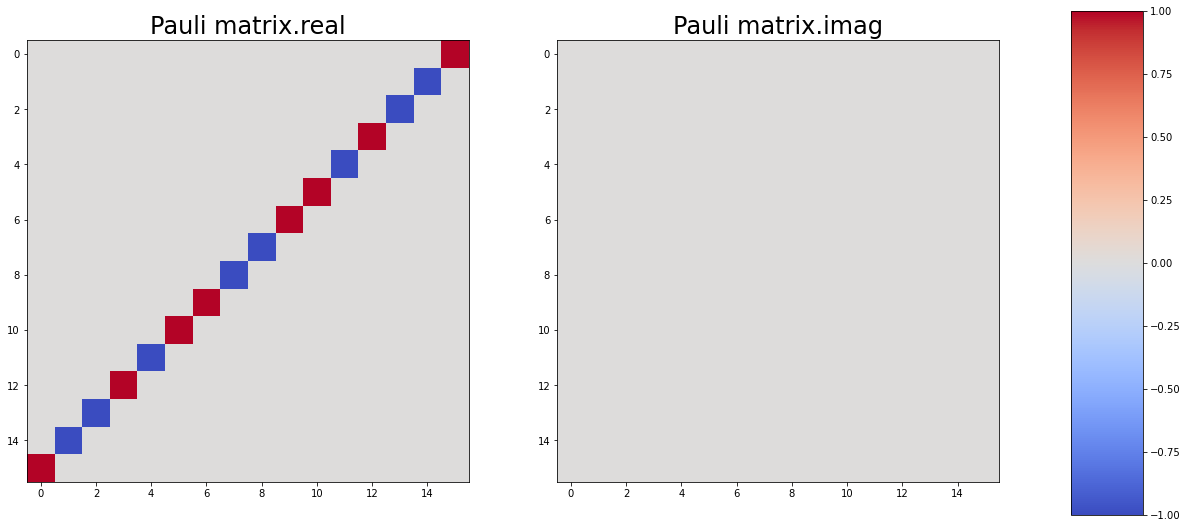

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
im = ax1.imshow(P_matr.real, cmap='coolwarm', norm=colors.CenteredNorm())
ax1.set_title('Pauli matrix.real', fontsize = 24)
ax2.imshow(P_matr.imag, cmap='coolwarm', vmin=np.min(P_matr.real), vmax=np.max(P_matr.real))
ax2.set_title('Pauli matrix.imag', fontsize = 24)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

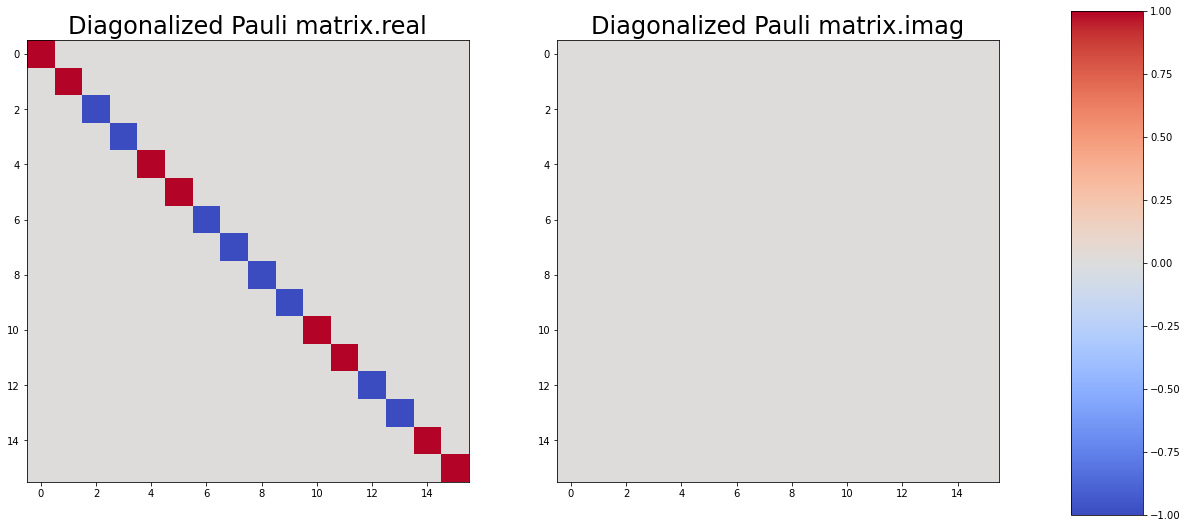

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
im = ax1.imshow(diag_P.real, cmap='coolwarm', norm=colors.CenteredNorm())
ax1.set_title('Diagonalized Pauli matrix.real', fontsize = 24)
ax2.imshow(diag_P.imag, cmap='coolwarm', vmin=np.min(diag_P.real), vmax=np.max(diag_P.real))
ax2.set_title('Diagonalized Pauli matrix.imag', fontsize = 24)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()